In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import time
import logging
from multiprocessing import Pool, cpu_count
import traceback

import sys
sys.path.append('../python')

import utils
import examples
from optimal import OptimalStrategy
from nominal import NominalStrategy
from ofu import OFUStrategy
from sls import SLS_FIRStrategy, SLS_CommonLyapunovStrategy, sls_common_lyapunov, SLSInfeasibleException
from ts import TSStrategy
from lspi import LSPIStrategy

import matplotlib.pylab as plt
import seaborn as sns
sns.set_style('ticks')

logging.basicConfig(level=logging.DEBUG)

In [48]:
# PARAMETERS
rng = np.random
horizon = 10000
trials_per_method = 10

## Defining True System Dynamics

In [3]:
def set_up_example(A_star, B_star, qr_ratio, prime_horizon, prime_excitation, sigma_excitation=0.1):
    n,p = B_star.shape
    # design a stabilizing controller
    _, K_init = utils.dlqr(A_star, B_star, 1e-3*np.eye(n), np.eye(p))
    assert utils.spectral_radius(A_star + B_star.dot(K_init)) < 1
    Q = qr_ratio * np.eye(n)
    R = np.eye(p)
    sigma_w = 1
    return A_star, B_star, K_init, Q, R, prime_horizon, prime_excitation, sigma_excitation, sigma_w

def laplacian_dynamics(qr_ratio=1e1, prime_horizon=100, prime_excitation=1):
    A_star, B_star = examples.unstable_laplacian_dynamics()
    return set_up_example(A_star, B_star, qr_ratio, prime_horizon, prime_excitation)

def unstable_dynamics(qr_ratio=1e1, prime_horizon=250, prime_excitation=2):
    A_star, B_star = examples.transient_dynamics(diag_coeff=2, upperdiag=4)
    return set_up_example(A_star, B_star, qr_ratio, prime_horizon, prime_excitation, sigma_excitation=0.1)

In [10]:
example = laplacian_dynamics() # unstable_dynamics()
A_star, B_star, K_init, Q, R, prime_horizon, prime_excitation, sigma_excitation, sigma_w = example
prime_horizon = 1000

print(A_star)
print(B_star)
print(K_init)
print("prime_horizon", prime_horizon)
print("prime_excitation", prime_excitation)
print("sigma_excitation", sigma_excitation)

[[1.01 0.01 0.  ]
 [0.01 1.01 0.01]
 [0.   0.01 1.01]]
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
[[-0.04373095 -0.01250864 -0.00126936]
 [-0.01250864 -0.04500031 -0.01250864]
 [-0.00126936 -0.01250864 -0.04373095]]
prime_horizon 1000
prime_excitation 1
sigma_excitation 0.1


# Constructors for different adaptive methods

In [18]:
def optimal_ctor():
    return OptimalStrategy(Q=Q, R=R, A_star=A_star, B_star=B_star, sigma_w=sigma_w)

def nominal_ctor():
    return NominalStrategy(Q=Q,
                          R=R,
                          A_star=A_star,
                          B_star=B_star,
                          sigma_w=sigma_w,
                          sigma_explore=sigma_excitation,
                          reg=1e-5,
                          epoch_multiplier=10, rls_lam=None)

def ofu_ctor():
    return OFUStrategy(Q=Q,
                  R=R,
                  A_star=A_star,
                  B_star=B_star,
                  sigma_w=sigma_w,
                  reg=1e-5,
                  actual_error_multiplier=1, rls_lam=None)

def ts_ctor():
    return TSStrategy(Q=Q,
                  R=R,
                  A_star=A_star,
                  B_star=B_star,
                  sigma_w=sigma_w,
                  reg=1e-5,
                  tau=500,
                  actual_error_multiplier=1, rls_lam=None)

def sls_fir_ctor():
    return SLS_FIRStrategy(Q=Q,
                  R=R,
                  A_star=A_star,
                  B_star=B_star,
                  sigma_w=sigma_w,
                  sigma_explore=sigma_excitation,
                  reg=1e-5,
                  epoch_multiplier=10,
                  truncation_length=12,
                  actual_error_multiplier=1, rls_lam=None)

def sls_cl_ctor():
    return SLS_CommonLyapunovStrategy(Q=Q,
                  R=R,
                  A_star=A_star,
                  B_star=B_star,
                  sigma_w=sigma_w,
                  sigma_explore=sigma_excitation,
                  reg=1e-5,
                  epoch_multiplier=10,
                  actual_error_multiplier=1, rls_lam=None)

def lspi_ctor():
    return LSPIStrategy(Q=Q,
                        R=R,
                        A_star=A_star,
                        B_star=B_star,
                        sigma_w=sigma_w,
                        sigma_explore=sigma_excitation,
                        epoch_multiplier=10,
                        num_PI_iters=3,
                        K_init=K_init)

# Helper methods for running in parallel

In [6]:
prime_seed = 45727
def run_one_trial(new_env_ctor, seed, prime_fixed=False):
    rng = np.random.RandomState(seed)
    if prime_fixed: # reducing variance
        rng_prime = np.random.RandomState(prime_seed) 
    else:
        rng_prime = rng
    env = new_env_ctor()
    env.reset(rng_prime)
    env.prime(prime_horizon, K_init, prime_excitation, rng_prime)
    regret = np.array([env.step(rng) for _ in range(horizon)])
    env.complete_epoch(rng)
    err, cost = env.get_statistics(iteration_based=True)
    return regret, err, cost

def spawn_invocation(method, p, prime_fixed=False):
    seed = np.random.randint(0xFFFFFFFF)
    ctor = {
        'optimal': optimal_ctor,
        'nominal': nominal_ctor,
        'ofu': ofu_ctor,
        'ts': ts_ctor,
        'sls_fir': sls_fir_ctor,
        'sls_cl': sls_cl_ctor,
        'lspi': lspi_ctor,
    }[method]
    return (p.apply_async(run_one_trial, (ctor, seed, prime_fixed)), seed)

def process_future_list(ftchs):
    regrets = []
    errors = []
    costs = []
    seeds = []
    bad_invocations = 0
    for ftch, seed in ftchs:
        try:
            reg, err, cost = ftch.get()
        except Exception as e:
            traceback.print_exc()
            bad_invocations += 1
            continue
        regrets.append(reg)
        errors.append(err)
        costs.append(cost)
        seeds.append(seed)
    return np.array(regrets), np.array(errors), np.array(costs), np.array(seeds), bad_invocations

# Running experiments and plotting results

In [49]:
#strategies = ['optimal', 'nominal', 'ofu', 'ts', 'sls_fir', 'lspi']
strategies = ['optimal', 'nominal', 'lspi']
#strategies = ['optimal', 'nominal']
start_time = time.time()
with Pool(processes=cpu_count()) as p:
    all_futures = [[spawn_invocation(method, p, prime_fixed=True) 
                    for _ in range(trials_per_method)] for method in strategies]
    list_of_results = [process_future_list(ftchs) for ftchs in all_futures] 
print("finished execution in {} seconds".format(time.time() - start_time))

INFO:optimal:prime: eps_A=0.0, eps_B=0.0, Jnom=32.804256994922355
INFO:optimal:prime: eps_A=0.0, eps_B=0.0, Jnom=32.804256994922355
INFO:optimal:prime: eps_A=0.0, eps_B=0.0, Jnom=32.804256994922355
INFO:optimal:prime: eps_A=0.0, eps_B=0.0, Jnom=32.804256994922355
INFO:optimal:prime: eps_A=0.0, eps_B=0.0, Jnom=32.804256994922355
INFO:optimal:prime: eps_A=0.0, eps_B=0.0, Jnom=32.804256994922355
INFO:optimal:prime: eps_A=0.0, eps_B=0.0, Jnom=32.804256994922355
INFO:optimal:prime: eps_A=0.0, eps_B=0.0, Jnom=32.804256994922355
INFO:optimal:Finished with epoch 0, which lasted for 10000 out of 10000 iterations
INFO:optimal:Finished with epoch 0, which lasted for 10000 out of 10000 iterations
INFO:optimal:Regret=844.6654169571771, eps_A=0.0, eps_B=0.0, Jhat=32.804256994922355, elapsed_time_since_reset=0.44564318656921387
INFO:optimal:Regret=-897.2575155601845, eps_A=0.0, eps_B=0.0, Jhat=32.804256994922355, elapsed_time_since_reset=0.4468269348144531
INFO:optimal:Finished with epoch 0, which la

INFO:nominal:Regret=-90.56695671830602, eps_A=0.015743966642678606, eps_B=0.03019623747936551, Jhat=32.826672809377705, elapsed_time_since_reset=0.12155604362487793
INFO:nominal:Regret=271.45778040933305, eps_A=0.015595391663724171, eps_B=0.03744574514331233, Jhat=32.835225883541305, elapsed_time_since_reset=0.1406540870666504
INFO:nominal:_design_controller(epoch=2): rho(A_* + B_* K)=0.11031264424467332
INFO:nominal:_design_controller(epoch=3): rho(A_* + B_* K)=0.10995157865914246
INFO:nominal:Finished with epoch 1, which lasted for 20 out of 30 iterations
INFO:nominal:Finished with epoch 2, which lasted for 30 out of 60 iterations
INFO:nominal:Regret=-339.3080134041469, eps_A=0.01566557790401575, eps_B=0.03603399551111639, Jhat=32.83608774968224, elapsed_time_since_reset=0.12130475044250488
INFO:nominal:Regret=-63.96338710693409, eps_A=0.01567044627548377, eps_B=0.0359977510442387, Jhat=32.83307872619729, elapsed_time_since_reset=0.1290280818939209
INFO:nominal:_design_controller(epo

INFO:nominal:Regret=-545.2837447132999, eps_A=0.015961082261215054, eps_B=0.033795462293589984, Jhat=32.83718274384532, elapsed_time_since_reset=0.231309175491333
INFO:nominal:Finished with epoch 7, which lasted for 80 out of 360 iterations
INFO:nominal:Regret=706.5460690818147, eps_A=0.015668094156375007, eps_B=0.04220006173922976, Jhat=32.857018378946094, elapsed_time_since_reset=0.24078106880187988
INFO:nominal:_design_controller(epoch=7): rho(A_* + B_* K)=0.10367534074812429
INFO:nominal:_design_controller(epoch=8): rho(A_* + B_* K)=0.1007197976082021
INFO:nominal:Finished with epoch 6, which lasted for 70 out of 280 iterations
INFO:nominal:_design_controller(epoch=8): rho(A_* + B_* K)=0.10435211085825605
INFO:nominal:Regret=-502.8310466631264, eps_A=0.015835950224206034, eps_B=0.036925143208676556, Jhat=32.837351135434325, elapsed_time_since_reset=0.2245488166809082
INFO:nominal:Finished with epoch 7, which lasted for 80 out of 360 iterations
INFO:nominal:Finished with epoch 7, wh

INFO:nominal:Regret=-627.6223569146807, eps_A=0.015879147151730402, eps_B=0.03359226305279624, Jhat=32.82389317461278, elapsed_time_since_reset=0.34419989585876465
INFO:nominal:Finished with epoch 11, which lasted for 120 out of 780 iterations
INFO:nominal:Regret=833.9380166922333, eps_A=0.015963585522673917, eps_B=0.04698448551289555, Jhat=32.84196683466084, elapsed_time_since_reset=0.34962987899780273
INFO:nominal:_design_controller(epoch=12): rho(A_* + B_* K)=0.08519650057484975
INFO:nominal:Finished with epoch 11, which lasted for 120 out of 780 iterations
INFO:nominal:Regret=1109.288973676056, eps_A=0.015641027099785473, eps_B=0.03898468985209688, Jhat=32.82405090990612, elapsed_time_since_reset=0.33809399604797363
INFO:nominal:Regret=21.550116431192556, eps_A=0.016102636015430473, eps_B=0.05711149275612412, Jhat=32.83358101720714, elapsed_time_since_reset=0.35940098762512207
INFO:nominal:_design_controller(epoch=12): rho(A_* + B_* K)=0.1134734380856005
INFO:nominal:Finished with 

INFO:nominal:_design_controller(epoch=16): rho(A_* + B_* K)=0.10599666267264451
INFO:nominal:_design_controller(epoch=16): rho(A_* + B_* K)=0.08875868922172235
INFO:nominal:Finished with epoch 15, which lasted for 160 out of 1360 iterations
INFO:nominal:Regret=-541.9225689847725, eps_A=0.016071096020573158, eps_B=0.03446928331656304, Jhat=32.817320021192664, elapsed_time_since_reset=0.5028438568115234
INFO:nominal:_design_controller(epoch=16): rho(A_* + B_* K)=0.1064248422591294
INFO:nominal:Finished with epoch 15, which lasted for 160 out of 1360 iterations
INFO:nominal:Regret=1662.2751174780997, eps_A=0.01536647539209653, eps_B=0.04862075412298562, Jhat=32.83861032364017, elapsed_time_since_reset=0.4904959201812744
INFO:nominal:Finished with epoch 15, which lasted for 160 out of 1360 iterations
INFO:nominal:Regret=-1277.8517667205256, eps_A=0.015869025604374032, eps_B=0.03638094698738903, Jhat=32.8260743736827, elapsed_time_since_reset=0.48753881454467773
INFO:nominal:_design_control

INFO:nominal:Regret=-763.9042856326533, eps_A=0.01592621533270636, eps_B=0.05701396074620947, Jhat=32.84237702192391, elapsed_time_since_reset=0.703559160232544
INFO:nominal:Regret=-1069.7499971765274, eps_A=0.01621719854701831, eps_B=0.040375487757415486, Jhat=32.82866775215561, elapsed_time_since_reset=0.7200949192047119
INFO:nominal:Regret=-1598.3126476635632, eps_A=0.016022026068460406, eps_B=0.031146098745546007, Jhat=32.82078388299398, elapsed_time_since_reset=0.7009878158569336
INFO:optimal:Finished with epoch 0, which lasted for 10000 out of 10000 iterations
INFO:optimal:Regret=6186.487498999744, eps_A=0.0, eps_B=0.0, Jhat=32.804256994922355, elapsed_time_since_reset=0.7628002166748047
INFO:nominal:_design_controller(epoch=20): rho(A_* + B_* K)=0.09094877435498351
INFO:nominal:Finished with epoch 19, which lasted for 200 out of 2100 iterations
INFO:nominal:Regret=1926.8810671344247, eps_A=0.015338744205563715, eps_B=0.04441243905062803, Jhat=32.8337637415218, elapsed_time_since

INFO:nominal:Finished with epoch 22, which lasted for 230 out of 2760 iterations
INFO:nominal:Regret=2780.9635890203836, eps_A=0.015491293127331265, eps_B=0.046995492444212666, Jhat=32.83150390232953, elapsed_time_since_reset=0.8875751495361328
INFO:nominal:Finished with epoch 0, which lasted for 10 out of 10 iterations
INFO:nominal:Regret=-39.9279571146056, eps_A=0.015611130575568908, eps_B=0.03377725350429084, Jhat=32.83233450743232, elapsed_time_since_reset=0.08676791191101074
INFO:nominal:_design_controller(epoch=24): rho(A_* + B_* K)=0.11795475062050301
INFO:nominal:Finished with epoch 23, which lasted for 240 out of 3000 iterations
INFO:nominal:Regret=-1461.717602509913, eps_A=0.01577105067707001, eps_B=0.058670892759538594, Jhat=32.84349249925373, elapsed_time_since_reset=0.8957538604736328
INFO:nominal:_design_controller(epoch=4): rho(A_* + B_* K)=0.10549616611657184
INFO:nominal:Finished with epoch 3, which lasted for 40 out of 100 iterations
INFO:nominal:Regret=-46.5992436575

INFO:nominal:Regret=-1538.0853230078656, eps_A=0.015571188106588066, eps_B=0.030133684929343596, Jhat=32.82403732488889, elapsed_time_since_reset=0.2465829849243164
INFO:nominal:_design_controller(epoch=26): rho(A_* + B_* K)=0.09298786528183375
INFO:nominal:Finished with epoch 24, which lasted for 250 out of 3250 iterations
INFO:nominal:Finished with epoch 25, which lasted for 260 out of 3510 iterations
INFO:nominal:Finished with epoch 25, which lasted for 260 out of 3510 iterations
INFO:nominal:Regret=2189.8805476185157, eps_A=0.016147917495257968, eps_B=0.03568305062184151, Jhat=32.81306172276591, elapsed_time_since_reset=1.0736439228057861
INFO:nominal:Regret=-579.0113207189606, eps_A=0.016038866353873957, eps_B=0.02875322880159888, Jhat=32.80743007203282, elapsed_time_since_reset=1.0709431171417236
INFO:nominal:_design_controller(epoch=10): rho(A_* + B_* K)=0.11312549239471562
INFO:nominal:Regret=-1958.6385044178007, eps_A=0.015774938041777146, eps_B=0.0571732816226757, Jhat=32.840

INFO:nominal:Regret=-1810.6717540298403, eps_A=0.015721750270110517, eps_B=0.01731928720658108, Jhat=32.81193862750112, elapsed_time_since_reset=0.4435579776763916
INFO:nominal:Regret=543.8762299563859, eps_A=0.016072019909186726, eps_B=0.02765454305604395, Jhat=32.81553150564246, elapsed_time_since_reset=0.4954259395599365
INFO:nominal:_design_controller(epoch=28): rho(A_* + B_* K)=0.0946814295644324
INFO:nominal:Regret=-2442.895922040763, eps_A=0.015751540932532875, eps_B=0.05148411693791297, Jhat=32.83734001637899, elapsed_time_since_reset=1.2569818496704102
INFO:nominal:Finished with epoch 27, which lasted for 280 out of 4060 iterations
INFO:nominal:_design_controller(epoch=15): rho(A_* + B_* K)=0.10678370353908591
INFO:nominal:_design_controller(epoch=29): rho(A_* + B_* K)=0.09016088245647365
INFO:nominal:Regret=2591.592984263117, eps_A=0.01543594472781713, eps_B=0.046572912539917105, Jhat=32.833804835704065, elapsed_time_since_reset=1.266650915145874
INFO:nominal:Finished with ep

INFO:nominal:_design_controller(epoch=32): rho(A_* + B_* K)=0.09925390891060984
INFO:nominal:_design_controller(epoch=31): rho(A_* + B_* K)=0.09705589234995646
INFO:nominal:Finished with epoch 30, which lasted for 310 out of 4960 iterations
INFO:nominal:_design_controller(epoch=32): rho(A_* + B_* K)=0.11333248517670814
INFO:nominal:Regret=-476.6073117869322, eps_A=0.01593628808603213, eps_B=0.03788306822170448, Jhat=32.811274840412246, elapsed_time_since_reset=1.5731899738311768
INFO:nominal:Finished with epoch 31, which lasted for 320 out of 5280 iterations
INFO:nominal:Finished with epoch 31, which lasted for 320 out of 5280 iterations
INFO:nominal:_design_controller(epoch=31): rho(A_* + B_* K)=0.09190183277597537
INFO:nominal:_design_controller(epoch=18): rho(A_* + B_* K)=0.11754241139311004
INFO:nominal:Finished with epoch 17, which lasted for 180 out of 1710 iterations
INFO:nominal:_design_controller(epoch=18): rho(A_* + B_* K)=0.09834614527884102
INFO:nominal:_design_controller(e

INFO:nominal:_design_controller(epoch=20): rho(A_* + B_* K)=0.09215180140408058
INFO:nominal:Finished with epoch 19, which lasted for 200 out of 2100 iterations
INFO:nominal:_design_controller(epoch=35): rho(A_* + B_* K)=0.09001607337413839
INFO:nominal:Regret=-2556.023920558706, eps_A=0.015682915709888577, eps_B=0.02345618597188438, Jhat=32.81413210839068, elapsed_time_since_reset=1.04555082321167
INFO:nominal:Regret=69.8241884590726, eps_A=0.015974077096354816, eps_B=0.038081063362867644, Jhat=32.812905954630054, elapsed_time_since_reset=1.8627820014953613
INFO:nominal:_design_controller(epoch=34): rho(A_* + B_* K)=0.10118405810458617
INFO:nominal:_design_controller(epoch=21): rho(A_* + B_* K)=0.09019428489382435
INFO:nominal:Finished with epoch 33, which lasted for 340 out of 5950 iterations
INFO:nominal:Finished with epoch 34, which lasted for 350 out of 6300 iterations
INFO:nominal:Finished with epoch 20, which lasted for 210 out of 2310 iterations
INFO:nominal:Regret=3005.2196406

INFO:nominal:Regret=-890.8166794064136, eps_A=0.01595548748697825, eps_B=0.043130049962610675, Jhat=32.815572100489014, elapsed_time_since_reset=2.098541021347046
INFO:nominal:_design_controller(epoch=25): rho(A_* + B_* K)=0.10346823588028567
INFO:nominal:Regret=4368.299198208713, eps_A=0.01544852529042571, eps_B=0.04875747082539167, Jhat=32.825307056755705, elapsed_time_since_reset=2.0866570472717285
INFO:nominal:Finished with epoch 24, which lasted for 250 out of 3250 iterations
INFO:nominal:_design_controller(epoch=38): rho(A_* + B_* K)=0.09391416080723271
INFO:nominal:Finished with epoch 37, which lasted for 380 out of 7410 iterations
INFO:nominal:Regret=-2752.588382769885, eps_A=0.015753745756326622, eps_B=0.027503383127589612, Jhat=32.81737210270466, elapsed_time_since_reset=1.308701992034912
INFO:nominal:Regret=3036.369700804224, eps_A=0.015884703511789115, eps_B=0.03237901803736796, Jhat=32.81243040951678, elapsed_time_since_reset=2.132056713104248
INFO:nominal:_design_controll

INFO:nominal:Regret=-536.7062524866384, eps_A=0.01581997018197585, eps_B=0.03157873730088667, Jhat=32.81763822233903, elapsed_time_since_reset=2.3126659393310547
INFO:nominal:Regret=2444.496296727723, eps_A=0.015991059449684254, eps_B=0.02440918140882332, Jhat=32.81423294858146, elapsed_time_since_reset=1.5685679912567139
INFO:nominal:Regret=5554.115506935477, eps_A=0.015345532081812874, eps_B=0.039597136015339464, Jhat=32.81982209782309, elapsed_time_since_reset=2.321852922439575
INFO:nominal:_design_controller(epoch=41): rho(A_* + B_* K)=0.09005822035753464
INFO:nominal:_design_controller(epoch=41): rho(A_* + B_* K)=0.10426256474506496
INFO:nominal:Finished with epoch 40, which lasted for 410 out of 8610 iterations
INFO:nominal:_design_controller(epoch=29): rho(A_* + B_* K)=0.09704101905192608
INFO:nominal:_design_controller(epoch=40): rho(A_* + B_* K)=0.10520110937778131
INFO:nominal:Finished with epoch 40, which lasted for 410 out of 8610 iterations
INFO:nominal:Finished with epoch

INFO:nominal:Regret=1848.2421396854484, eps_A=0.01585317191175963, eps_B=0.03152223320049471, Jhat=32.81553678045108, elapsed_time_since_reset=1.8336350917816162
INFO:nominal:Regret=1533.5978118775677, eps_A=0.015859500016310913, eps_B=0.0374327813937032, Jhat=32.81374329945231, elapsed_time_since_reset=2.58204984664917
INFO:nominal:_design_controller(epoch=43): rho(A_* + B_* K)=0.094715388418395
INFO:nominal:Finished with epoch 42, which lasted for 430 out of 9460 iterations
INFO:nominal:_design_controller(epoch=42): rho(A_* + B_* K)=0.09396160550862015
INFO:nominal:Regret=-2141.528993527401, eps_A=0.015811745258293358, eps_B=0.020956499121430616, Jhat=32.81151497102401, elapsed_time_since_reset=2.604888916015625
INFO:nominal:Finished with epoch 41, which lasted for 420 out of 9030 iterations
INFO:nominal:Regret=4426.249644366892, eps_A=0.015357012318209665, eps_B=0.03757890231175061, Jhat=32.81617649055798, elapsed_time_since_reset=2.6071438789367676
INFO:nominal:_design_controller(e

INFO:lspi:_design_controller(epoch=0): n_transitions=1000
INFO:nominal:Regret=-2215.936333919524, eps_A=0.015640191604418076, eps_B=0.023665720962442943, Jhat=32.81176956454216, elapsed_time_since_reset=2.116564989089966
INFO:lspi:_design_controller(epoch=0): n_transitions=1000
INFO:nominal:Finished with epoch 1, which lasted for 20 out of 30 iterations
INFO:nominal:_design_controller(epoch=2): rho(A_* + B_* K)=0.10455533177124063
INFO:nominal:_design_controller(epoch=38): rho(A_* + B_* K)=0.10699820812773805
INFO:nominal:Finished with epoch 1, which lasted for 20 out of 30 iterations
INFO:nominal:Finished with epoch 37, which lasted for 380 out of 7410 iterations
INFO:nominal:Regret=-95.22508551377513, eps_A=0.015539335959417871, eps_B=0.03395392337567527, Jhat=32.830949824385925, elapsed_time_since_reset=0.12884998321533203
INFO:nominal:Regret=-174.14171206653003, eps_A=0.015751888320461184, eps_B=0.03011702679774475, Jhat=32.81434816808913, elapsed_time_since_reset=2.212440013885498

INFO:nominal:Finished with epoch 10, which lasted for 110 out of 660 iterations
INFO:nominal:Regret=690.9441817062549, eps_A=0.01562076298485492, eps_B=0.03228698871337518, Jhat=32.814522902049916, elapsed_time_since_reset=0.34790682792663574
INFO:nominal:Regret=-1006.3901766466026, eps_A=0.016226752190599283, eps_B=0.042239573223433184, Jhat=32.83400281761789, elapsed_time_since_reset=0.3597710132598877
INFO:nominal:_design_controller(epoch=39): rho(A_* + B_* K)=0.08408493358775378
INFO:nominal:_design_controller(epoch=12): rho(A_* + B_* K)=0.1113525552427396
INFO:nominal:Finished with epoch 38, which lasted for 390 out of 7800 iterations
INFO:nominal:Finished with epoch 11, which lasted for 120 out of 780 iterations
INFO:nominal:Regret=-901.1476486585677, eps_A=0.016271908319077096, eps_B=0.04567184956422821, Jhat=32.8355057432596, elapsed_time_since_reset=0.3798840045928955
INFO:nominal:_design_controller(epoch=12): rho(A_* + B_* K)=0.09464850129006858
INFO:nominal:Finished with epo

INFO:nominal:Finished with epoch 43, which lasted for 440 out of 9900 iterations
INFO:nominal:Regret=1566.3566354197712, eps_A=0.01596207440671067, eps_B=0.02403277994369378, Jhat=32.812061428588954, elapsed_time_since_reset=2.725660800933838
INFO:nominal:_design_controller(epoch=20): rho(A_* + B_* K)=0.0903704206191032
INFO:nominal:_design_controller(epoch=43): rho(A_* + B_* K)=0.08498310207106026
INFO:nominal:Finished with epoch 19, which lasted for 200 out of 2100 iterations
INFO:nominal:Regret=2708.2923399105184, eps_A=0.01576899572636025, eps_B=0.044356575237049806, Jhat=32.81485935656388, elapsed_time_since_reset=0.6637442111968994
INFO:nominal:Finished with epoch 42, which lasted for 430 out of 9460 iterations
INFO:nominal:_design_controller(epoch=21): rho(A_* + B_* K)=0.10434389043721176
INFO:nominal:Regret=-1211.4106987796151, eps_A=0.01558032318977928, eps_B=0.025751958358143583, Jhat=32.81159407234592, elapsed_time_since_reset=2.712272882461548
INFO:nominal:Finished with epo

INFO:nominal:Finished with epoch 29, which lasted for 300 out of 4650 iterations
INFO:nominal:Regret=1621.450291398213, eps_A=0.015859801443953325, eps_B=0.03867940384566966, Jhat=32.811872313692, elapsed_time_since_reset=1.2724800109863281
INFO:nominal:_design_controller(epoch=31): rho(A_* + B_* K)=0.08386381284579918
INFO:nominal:_design_controller(epoch=31): rho(A_* + B_* K)=0.10223987013283477
INFO:nominal:Finished with epoch 30, which lasted for 310 out of 4960 iterations
INFO:nominal:Finished with epoch 30, which lasted for 310 out of 4960 iterations
INFO:nominal:Regret=639.56960986321, eps_A=0.015738407781999357, eps_B=0.03791661572022278, Jhat=32.819209969044735, elapsed_time_since_reset=1.3272638320922852
INFO:nominal:Regret=1906.6384662984287, eps_A=0.015899377294814877, eps_B=0.03847508660444408, Jhat=32.81150470109094, elapsed_time_since_reset=1.316922903060913
INFO:nominal:_design_controller(epoch=32): rho(A_* + B_* K)=0.07961274637906386
INFO:nominal:_design_controller(ep

INFO:nominal:Regret=2237.9602345478233, eps_A=0.016297564087505594, eps_B=0.026813974833011386, Jhat=32.80692989178763, elapsed_time_since_reset=2.065404176712036
INFO:nominal:_design_controller(epoch=43): rho(A_* + B_* K)=0.09098215424885041
INFO:lspi:num_iters=3
INFO:nominal:Finished with epoch 42, which lasted for 430 out of 9460 iterations
INFO:nominal:Regret=72.32932177565888, eps_A=0.0160044635179314, eps_B=0.038359278324174746, Jhat=32.814860319442346, elapsed_time_since_reset=2.0636370182037354
INFO:nominal:_design_controller(epoch=44): rho(A_* + B_* K)=0.09332925018328554
INFO:lspi:num_iters=3
INFO:nominal:_design_controller(epoch=44): rho(A_* + B_* K)=0.08931988615460444
INFO:nominal:Finished with epoch 43, which lasted for 440 out of 9900 iterations
INFO:nominal:Finished with epoch 43, which lasted for 440 out of 9900 iterations
INFO:nominal:Regret=-8.76554916347331, eps_A=0.016013586545696866, eps_B=0.036224504908599624, Jhat=32.813776821181456, elapsed_time_since_reset=2.1

INFO:lspi:_design_controller(epoch=4): n_transitions=1100
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=4): rho(A_* + B_* K)=2.6956347216318477
INFO:lspi:_design_controller(epoch=3): rho(A_* + B_* K)=0.43888214262862146
INFO:lspi:Finished with epoch 2, which lasted for 30 out of 60 iterations
INFO:lspi:Finished with epoch 3, which lasted for 40 out of 100 iterations
INFO:lspi:Regret=462.4937232629765, eps_A=0.0, eps_B=0.0, Jhat=36.39290789172932, elapsed_time_since_reset=3.31074595451355
INFO:lspi:Regret=1.08235285844476e+19, eps_A=0.0, eps_B=0.0, Jhat=inf, elapsed_time_since_reset=3.4142251014709473
INFO:lspi:_design_controller(epoch=4): n_transitions=1100
INFO:lspi:_design_controller(epoch=5): n_transitions=1150
INFO:lspi:num_iters=3
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=5): rho(A_* + B_* K)=0.43711772388814496
INFO:lspi:Finished with epoch 4, which lasted for 50 out of 150 iterations
INFO:lspi:Regret=750.5676542380838, eps_A=0.0, eps_B=0.0, Jhat=36.3702

INFO:lspi:Regret=1398.7484837598324, eps_A=0.0, eps_B=0.0, Jhat=35.61720143509343, elapsed_time_since_reset=3.6790659427642822
INFO:lspi:_design_controller(epoch=9): n_transitions=1450
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=10): rho(A_* + B_* K)=1.0090766622012894
INFO:lspi:Finished with epoch 9, which lasted for 100 out of 550 iterations
INFO:lspi:_design_controller(epoch=0): rho(A_* + B_* K)=0.5029318252989398
INFO:lspi:Regret=6.308474354330275e+101, eps_A=0.0, eps_B=0.0, Jhat=inf, elapsed_time_since_reset=3.805413007736206
INFO:lspi:_design_controller(epoch=9): rho(A_* + B_* K)=0.4329958099342611
INFO:lspi:prime: eps_A=0.0, eps_B=0.0, Jnom=36.6960947027563
INFO:lspi:Finished with epoch 8, which lasted for 90 out of 450 iterations
INFO:lspi:_design_controller(epoch=10): rho(A_* + B_* K)=0.43498588717969244
INFO:lspi:Finished with epoch 9, which lasted for 100 out of 550 iterations
INFO:lspi:_design_controller(epoch=11): n_transitions=1660
INFO:lspi:Regret=2676.17943

INFO:lspi:_design_controller(epoch=4): n_transitions=1100
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=13): n_transitions=1910
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=13): rho(A_* + B_* K)=0.42180969490685327
INFO:lspi:Finished with epoch 12, which lasted for 130 out of 910 iterations
INFO:lspi:Regret=2048.367541439942, eps_A=0.0, eps_B=0.0, Jhat=35.163525885119256, elapsed_time_since_reset=3.9894888401031494
INFO:lspi:_design_controller(epoch=1): rho(A_* + B_* K)=0.8152470757326814
INFO:lspi:Finished with epoch 0, which lasted for 10 out of 10 iterations
INFO:lspi:Regret=-158.13878553809818, eps_A=0.0, eps_B=0.0, Jhat=64.17819100505018, elapsed_time_since_reset=0.25894904136657715
INFO:lspi:_design_controller(epoch=4): rho(A_* + B_* K)=0.4425521568219208
INFO:lspi:_design_controller(epoch=2): n_transitions=1030
INFO:lspi:num_iters=3
INFO:lspi:Finished with epoch 3, which lasted for 40 out of 100 iterations
INFO:lspi:Regret=603.6545703024887, eps_A=0.0, eps

INFO:lspi:num_iters=4
INFO:lspi:_design_controller(epoch=6): n_transitions=1210
INFO:lspi:_design_controller(epoch=9): n_transitions=1450
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=8): rho(A_* + B_* K)=0.44136649255169275
INFO:lspi:num_iters=3
INFO:lspi:Finished with epoch 7, which lasted for 80 out of 360 iterations
INFO:lspi:Regret=1501.8329420510167, eps_A=0.0, eps_B=0.0, Jhat=35.80077916599569, elapsed_time_since_reset=3.6673412322998047
INFO:lspi:_design_controller(epoch=9): n_transitions=1450
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=6): rho(A_* + B_* K)=0.44123419298528466
INFO:lspi:Finished with epoch 5, which lasted for 60 out of 210 iterations
INFO:lspi:Regret=1454.9293606714073, eps_A=0.0, eps_B=0.0, Jhat=35.68824694678075, elapsed_time_since_reset=0.609583854675293
INFO:lspi:_design_controller(epoch=16): rho(A_* + B_* K)=0.41449840092907425
INFO:lspi:Finished with epoch 15, which lasted for 160 out of 1360 iterations
INFO:lspi:Regret=3722.201820

INFO:lspi:Regret=5983.419606523811, eps_A=0.0, eps_B=0.0, Jhat=34.86220956951389, elapsed_time_since_reset=4.931236028671265
INFO:lspi:_design_controller(epoch=20): n_transitions=3100
INFO:lspi:_design_controller(epoch=13): rho(A_* + B_* K)=0.41971217966699875
INFO:lspi:Finished with epoch 12, which lasted for 130 out of 910 iterations
INFO:lspi:_design_controller(epoch=11): rho(A_* + B_* K)=0.43514503007904537
INFO:lspi:Regret=446.3616957718283, eps_A=0.0, eps_B=0.0, Jhat=35.09087566750448, elapsed_time_since_reset=4.0852131843566895
INFO:lspi:Finished with epoch 10, which lasted for 110 out of 660 iterations
INFO:lspi:Regret=2679.0382745567713, eps_A=0.0, eps_B=0.0, Jhat=35.32959513812327, elapsed_time_since_reset=1.0648300647735596
INFO:lspi:num_iters=4
INFO:lspi:_design_controller(epoch=13): rho(A_* + B_* K)=0.4269129977833479
INFO:lspi:Finished with epoch 12, which lasted for 130 out of 910 iterations
INFO:lspi:_design_controller(epoch=14): n_transitions=2050
INFO:lspi:Regret=2027

INFO:lspi:Finished with epoch 14, which lasted for 150 out of 1200 iterations
INFO:lspi:Regret=4513.789342619824, eps_A=0.0, eps_B=0.0, Jhat=35.18311619151746, elapsed_time_since_reset=1.6351490020751953
INFO:lspi:_design_controller(epoch=17): rho(A_* + B_* K)=0.42133028268541994
INFO:lspi:_design_controller(epoch=16): n_transitions=2360
INFO:lspi:num_iters=4
INFO:lspi:Finished with epoch 16, which lasted for 170 out of 1530 iterations
INFO:lspi:Regret=4426.307376770458, eps_A=0.0, eps_B=0.0, Jhat=35.160511726334846, elapsed_time_since_reset=4.757094144821167
INFO:lspi:_design_controller(epoch=22): rho(A_* + B_* K)=0.38665007669826923
INFO:lspi:Finished with epoch 21, which lasted for 220 out of 2530 iterations
INFO:lspi:_design_controller(epoch=18): rho(A_* + B_* K)=0.400114088809935
INFO:lspi:Finished with epoch 17, which lasted for 180 out of 1710 iterations
INFO:lspi:_design_controller(epoch=18): n_transitions=2710
INFO:lspi:Regret=6779.48646852803, eps_A=0.0, eps_B=0.0, Jhat=34.43

INFO:lspi:_design_controller(epoch=2): rho(A_* + B_* K)=0.4498873279670174
INFO:lspi:num_iters=4
INFO:lspi:Finished with epoch 23, which lasted for 240 out of 3000 iterations
INFO:lspi:Regret=7026.768331040888, eps_A=0.0, eps_B=0.0, Jhat=34.30267795417234, elapsed_time_since_reset=5.76692795753479
INFO:lspi:_design_controller(epoch=24): rho(A_* + B_* K)=0.3974080988025314
INFO:lspi:Finished with epoch 1, which lasted for 20 out of 30 iterations
INFO:lspi:Finished with epoch 23, which lasted for 240 out of 3000 iterations
INFO:lspi:Regret=7002.870949011443, eps_A=0.0, eps_B=0.0, Jhat=34.43031772722671, elapsed_time_since_reset=5.851178884506226
INFO:lspi:Regret=1148.6373548305312, eps_A=0.0, eps_B=0.0, Jhat=35.47319879012491, elapsed_time_since_reset=3.7148139476776123
INFO:lspi:_design_controller(epoch=3): n_transitions=1060
INFO:lspi:_design_controller(epoch=25): rho(A_* + B_* K)=0.39566230939968206
INFO:lspi:num_iters=3
INFO:lspi:Finished with epoch 24, which lasted for 250 out of 32

INFO:lspi:_design_controller(epoch=7): n_transitions=1280
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=9): n_transitions=1450
INFO:lspi:Finished with epoch 22, which lasted for 230 out of 2760 iterations
INFO:lspi:num_iters=3
INFO:lspi:Regret=2454.904964571818, eps_A=0.0, eps_B=0.0, Jhat=34.39938432875927, elapsed_time_since_reset=5.548144102096558
INFO:lspi:_design_controller(epoch=23): n_transitions=3760
INFO:lspi:_design_controller(epoch=26): rho(A_* + B_* K)=0.3772128225421931
INFO:lspi:Finished with epoch 25, which lasted for 260 out of 3510 iterations
INFO:lspi:_design_controller(epoch=22): n_transitions=3530
INFO:lspi:Regret=8364.07559596725, eps_A=0.0, eps_B=0.0, Jhat=34.30685986804314, elapsed_time_since_reset=6.275044918060303
INFO:lspi:num_iters=4
INFO:lspi:num_iters=4
INFO:lspi:_design_controller(epoch=24): n_transitions=4000
INFO:lspi:_design_controller(epoch=27): rho(A_* + B_* K)=0.3886199249115723
INFO:lspi:num_iters=4
INFO:lspi:Finished with epoch 26, which 

INFO:lspi:Regret=4166.78711040327, eps_A=0.0, eps_B=0.0, Jhat=34.83546000262105, elapsed_time_since_reset=4.63832688331604
INFO:lspi:Finished with epoch 22, which lasted for 230 out of 2760 iterations
INFO:lspi:Regret=2622.962416492028, eps_A=0.0, eps_B=0.0, Jhat=34.84046733502588, elapsed_time_since_reset=4.645610094070435
INFO:lspi:Finished with epoch 27, which lasted for 280 out of 4060 iterations
INFO:lspi:Regret=6818.387208787869, eps_A=0.0, eps_B=0.0, Jhat=34.63211949487538, elapsed_time_since_reset=2.980823040008545
INFO:lspi:Regret=9103.045108185455, eps_A=0.0, eps_B=0.0, Jhat=34.26370441146777, elapsed_time_since_reset=6.720017910003662
INFO:lspi:num_iters=5
INFO:lspi:_design_controller(epoch=14): n_transitions=2050
INFO:lspi:_design_controller(epoch=13): n_transitions=1910
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=24): n_transitions=4000
INFO:lspi:num_iters=4
INFO:lspi:num_iters=4
INFO:lspi:_design_controller(epoch=29): n_transitions=5350
INFO:lspi:num_iters=5


INFO:lspi:num_iters=5
INFO:lspi:_design_controller(epoch=30): rho(A_* + B_* K)=0.3728214260027094
INFO:lspi:Finished with epoch 29, which lasted for 300 out of 4650 iterations
INFO:lspi:Regret=8000.802864627061, eps_A=0.0, eps_B=0.0, Jhat=34.15601225984581, elapsed_time_since_reset=7.52669095993042
INFO:lspi:_design_controller(epoch=26): rho(A_* + B_* K)=0.3913141548479703
INFO:lspi:Finished with epoch 25, which lasted for 260 out of 3510 iterations
INFO:lspi:Regret=7768.915201440959, eps_A=0.0, eps_B=0.0, Jhat=34.49931532242508, elapsed_time_since_reset=3.727424144744873
INFO:lspi:_design_controller(epoch=18): rho(A_* + B_* K)=0.4098168158972971
INFO:lspi:Finished with epoch 17, which lasted for 180 out of 1710 iterations
INFO:lspi:Regret=4019.907297370596, eps_A=0.0, eps_B=0.0, Jhat=34.479392179646986, elapsed_time_since_reset=5.418831825256348
INFO:lspi:_design_controller(epoch=31): n_transitions=5960
INFO:lspi:_design_controller(epoch=27): n_transitions=4780
INFO:lspi:num_iters=5
I

INFO:lspi:Finished with epoch 21, which lasted for 220 out of 2530 iterations
INFO:lspi:_design_controller(epoch=32): rho(A_* + B_* K)=0.3641492386023963
INFO:lspi:Finished with epoch 20, which lasted for 210 out of 2310 iterations
INFO:lspi:Regret=6073.823952167313, eps_A=0.0, eps_B=0.0, Jhat=34.43241361178879, elapsed_time_since_reset=5.945894956588745
INFO:lspi:Regret=5004.12606245634, eps_A=0.0, eps_B=0.0, Jhat=34.2465092119497, elapsed_time_since_reset=5.945319890975952
INFO:lspi:Finished with epoch 31, which lasted for 320 out of 5280 iterations
INFO:lspi:_design_controller(epoch=30): n_transitions=5650
INFO:lspi:_design_controller(epoch=33): n_transitions=6610
INFO:lspi:Regret=7447.645150705671, eps_A=0.0, eps_B=0.0, Jhat=34.07650963931769, elapsed_time_since_reset=8.090298175811768
INFO:lspi:num_iters=5
INFO:lspi:num_iters=6
INFO:lspi:_design_controller(epoch=22): n_transitions=3530
INFO:lspi:_design_controller(epoch=23): n_transitions=3760
INFO:lspi:_design_controller(epoch=31

INFO:lspi:_design_controller(epoch=35): rho(A_* + B_* K)=0.35787584994770916
INFO:lspi:Finished with epoch 30, which lasted for 310 out of 4960 iterations
INFO:lspi:Finished with epoch 34, which lasted for 350 out of 6300 iterations
INFO:lspi:Regret=12602.870174852365, eps_A=0.0, eps_B=0.0, Jhat=34.243785265124345, elapsed_time_since_reset=5.166270971298218
INFO:lspi:_design_controller(epoch=26): n_transitions=4510
INFO:lspi:Regret=10810.512892544626, eps_A=0.0, eps_B=0.0, Jhat=33.9623452843234, elapsed_time_since_reset=9.067015171051025
INFO:lspi:_design_controller(epoch=33): rho(A_* + B_* K)=0.3394606312856879
INFO:lspi:num_iters=5
INFO:lspi:_design_controller(epoch=35): n_transitions=7300
INFO:lspi:Finished with epoch 32, which lasted for 330 out of 5610 iterations
INFO:lspi:Regret=4517.298675678425, eps_A=0.0, eps_B=0.0, Jhat=33.99629787013208, elapsed_time_since_reset=8.202892065048218
INFO:lspi:_design_controller(epoch=32): n_transitions=6280
INFO:lspi:_design_controller(epoch=33

INFO:lspi:Finished with epoch 33, which lasted for 340 out of 5950 iterations
INFO:lspi:Finished with epoch 28, which lasted for 290 out of 4350 iterations
INFO:lspi:Regret=13686.074557723128, eps_A=0.0, eps_B=0.0, Jhat=34.13636467307489, elapsed_time_since_reset=6.2285850048065186
INFO:lspi:Regret=8698.142648296374, eps_A=0.0, eps_B=0.0, Jhat=34.14747065202226, elapsed_time_since_reset=7.904989004135132
INFO:lspi:_design_controller(epoch=35): rho(A_* + B_* K)=0.3470992495753515
INFO:lspi:_design_controller(epoch=37): rho(A_* + B_* K)=0.33577015430998974
INFO:lspi:Finished with epoch 34, which lasted for 350 out of 6300 iterations
INFO:lspi:Regret=10791.706074422573, eps_A=0.0, eps_B=0.0, Jhat=33.854105414370835, elapsed_time_since_reset=9.328794240951538
INFO:lspi:Finished with epoch 36, which lasted for 370 out of 7030 iterations
INFO:lspi:Regret=12183.706703536362, eps_A=0.0, eps_B=0.0, Jhat=33.8576299865663, elapsed_time_since_reset=9.989881038665771
INFO:lspi:_design_controller(ep

INFO:lspi:Regret=9059.931204419456, eps_A=0.0, eps_B=0.0, Jhat=33.80120211639443, elapsed_time_since_reset=11.109798192977905
INFO:lspi:_design_controller(epoch=39): n_transitions=8800
INFO:lspi:_design_controller(epoch=40): n_transitions=9200
INFO:lspi:_design_controller(epoch=33): rho(A_* + B_* K)=0.3603831108669196
INFO:lspi:num_iters=6
INFO:lspi:num_iters=6
INFO:lspi:Finished with epoch 32, which lasted for 330 out of 5610 iterations
INFO:lspi:Regret=9037.34024125063, eps_A=0.0, eps_B=0.0, Jhat=33.963695534362, elapsed_time_since_reset=9.062330722808838
INFO:lspi:_design_controller(epoch=40): rho(A_* + B_* K)=0.3386235951989594
INFO:lspi:Finished with epoch 39, which lasted for 400 out of 8200 iterations
INFO:lspi:Regret=12490.121170744434, eps_A=0.0, eps_B=0.0, Jhat=33.81022684582597, elapsed_time_since_reset=11.307982921600342
INFO:lspi:_design_controller(epoch=34): n_transitions=6950
INFO:lspi:num_iters=6
INFO:lspi:_design_controller(epoch=41): n_transitions=9610
INFO:lspi:_desi

INFO:lspi:num_iters=6
INFO:lspi:num_iters=6
INFO:lspi:_design_controller(epoch=42): rho(A_* + B_* K)=0.32113278985419386
INFO:lspi:Finished with epoch 41, which lasted for 420 out of 9030 iterations
INFO:lspi:Regret=8652.641012658514, eps_A=0.0, eps_B=0.0, Jhat=33.69284984741867, elapsed_time_since_reset=12.548825979232788
INFO:lspi:_design_controller(epoch=41): rho(A_* + B_* K)=0.31016800481624784
INFO:lspi:Finished with epoch 40, which lasted for 410 out of 8610 iterations
INFO:lspi:Regret=7264.543838509434, eps_A=0.0, eps_B=0.0, Jhat=33.69832665644992, elapsed_time_since_reset=11.779152154922485
INFO:lspi:_design_controller(epoch=36): rho(A_* + B_* K)=0.3490448853085626
INFO:lspi:Finished with epoch 35, which lasted for 360 out of 6660 iterations
INFO:lspi:Regret=9179.866022931368, eps_A=0.0, eps_B=0.0, Jhat=33.93084961680138, elapsed_time_since_reset=10.463944911956787
INFO:lspi:_design_controller(epoch=42): rho(A_* + B_* K)=0.31576116867688925
INFO:lspi:_design_controller(epoch=42

INFO:lspi:_design_controller(epoch=39): rho(A_* + B_* K)=0.33657492340389494
INFO:lspi:Finished with epoch 38, which lasted for 390 out of 7800 iterations
INFO:lspi:Regret=10343.523592555788, eps_A=0.0, eps_B=0.0, Jhat=33.84280505275064, elapsed_time_since_reset=11.924248218536377
INFO:lspi:_design_controller(epoch=0): n_transitions=1000
INFO:lspi:_design_controller(epoch=43): rho(A_* + B_* K)=0.3136542864511967
INFO:lspi:Finished with epoch 42, which lasted for 430 out of 9460 iterations
INFO:lspi:Regret=14614.133273494677, eps_A=0.0, eps_B=0.0, Jhat=33.589667894590725, elapsed_time_since_reset=13.360891103744507
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=40): n_transitions=9200
INFO:lspi:_design_controller(epoch=0): rho(A_* + B_* K)=0.5029318252989398
INFO:lspi:prime: eps_A=0.0, eps_B=0.0, Jnom=36.6960947027563
INFO:lspi:_design_controller(epoch=1): n_transitions=1010
INFO:lspi:num_iters=3
INFO:lspi:num_iters=6
INFO:lspi:_design_controller(epoch=45): rho(A_* + B_* K)=0.

INFO:lspi:_design_controller(epoch=12): n_transitions=1780
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=41): rho(A_* + B_* K)=0.32888722178935864
INFO:lspi:_design_controller(epoch=12): rho(A_* + B_* K)=0.4269017712688626
INFO:lspi:Finished with epoch 11, which lasted for 120 out of 780 iterations
INFO:lspi:Regret=2151.7003581154704, eps_A=0.0, eps_B=0.0, Jhat=35.15423585089994, elapsed_time_since_reset=0.9428658485412598
INFO:lspi:Finished with epoch 40, which lasted for 410 out of 8610 iterations
INFO:lspi:_design_controller(epoch=13): n_transitions=1910
INFO:lspi:Regret=11781.61819788779, eps_A=0.0, eps_B=0.0, Jhat=33.7656407779479, elapsed_time_since_reset=12.843255043029785
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=13): rho(A_* + B_* K)=0.4284050096523546
INFO:lspi:Finished with epoch 12, which lasted for 130 out of 910 iterations
INFO:lspi:Regret=3473.928161375291, eps_A=0.0, eps_B=0.0, Jhat=35.12302483883027, elapsed_time_since_reset=1.001734733581543


INFO:lspi:num_iters=5
INFO:lspi:_design_controller(epoch=45): rho(A_* + B_* K)=0.32165688948643784
INFO:lspi:Finished with epoch 44, which lasted for 100 out of 10000 iterations
INFO:lspi:Regret=8521.063572345209, eps_A=0.0, eps_B=0.0, Jhat=33.670455896659625, elapsed_time_since_reset=14.00334882736206
INFO:lspi:_design_controller(epoch=26): rho(A_* + B_* K)=0.38621179062038546
INFO:lspi:Finished with epoch 25, which lasted for 260 out of 3510 iterations
INFO:lspi:Regret=9618.2001107676, eps_A=0.0, eps_B=0.0, Jhat=34.345211524410956, elapsed_time_since_reset=2.191023826599121
INFO:lspi:_design_controller(epoch=27): n_transitions=4780
INFO:lspi:num_iters=5
INFO:lspi:_design_controller(epoch=45): rho(A_* + B_* K)=0.3144240324515415
INFO:lspi:Finished with epoch 44, which lasted for 100 out of 10000 iterations
INFO:lspi:Regret=13529.030438024596, eps_A=0.0, eps_B=0.0, Jhat=33.647245789758074, elapsed_time_since_reset=14.162575244903564
INFO:lspi:_design_controller(epoch=27): rho(A_* + B_*

finished execution in 23.30414605140686 seconds


In [52]:
trials_per_method

10

In [53]:
def get_errorbars(regrets, q=10, percent_bad=0):
    print(percent_bad)
    median = np.percentile(regrets, q=50-percent_bad, axis=0)
    low10 = np.percentile(regrets, q=q, axis=0)
    high90 = np.percentile(regrets, q=100-(q-percent_bad), axis=0)
    return median, low10, high90

def plot_list_medquantile(datalist, legendlist=None, xlabel=None, ylabel=None, semilogy=False, 
                          loc='upper left', alpha=0.1, figsize=(8,4)):
    rgblist = sns.color_palette('viridis', len(datalist))
    plt.figure(figsize=figsize)
    for idx, data in enumerate(datalist):
        median, lower, higher = data
        if semilogy:
            plt.semilogy(range(len(median)), median, color=rgblist[idx], label=legendlist[idx])
        else:
            plt.plot(range(len(median)), median, color=rgblist[idx], label=legendlist[idx])
        plt.fill_between(np.array(np.arange(len(median))), median.astype(np.float), 
                        higher.astype(np.float), color=rgblist[idx], alpha=alpha)
    if legendlist is not None:
        plt.legend(loc=loc)
    if xlabel is not None:
        plt.xlabel(xlabel)
    if ylabel is not None:
        plt.ylabel(ylabel)

optimal bad_invocations 0
0.0
0.0
nominal bad_invocations 0
0.0
0.0
lspi bad_invocations 1
10.0
10.0


/Users/stephentu/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/Users/stephentu/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "
/Users/stephentu/anaconda3/lib/python3.6/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


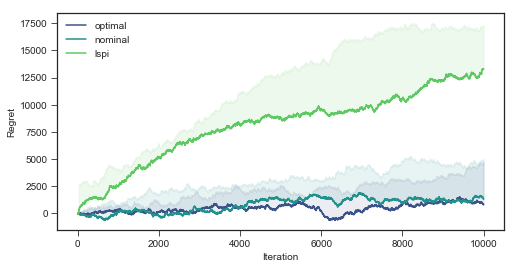

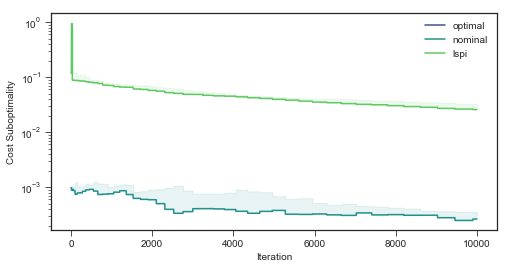

In [54]:
regretlist = []
costs_list = []

#strat_rearranged =  [strategies[2], strategies[3], strategies[1], strategies[0], strategies[4], strategies[5]]
#res_rearranged =  [list_of_results[2], list_of_results[3], list_of_results[1], list_of_results[0], list_of_results[4], list_of_results[5]]

strat_rearranged = strategies
res_rearranged = list_of_results

for name, result in zip(strat_rearranged, res_rearranged):
    regrets, errors, costs, _, bad_invocations = result
    print(name, "bad_invocations", bad_invocations)
    percent_bad = bad_invocations / trials_per_method * 100
    regretlist.append(get_errorbars(regrets, q=10, percent_bad=percent_bad))
    costs_list.append(get_errorbars(costs, q=10, percent_bad=percent_bad))

sns.set_palette("muted")
plot_list_medquantile(regretlist, legendlist=strat_rearranged, xlabel="Iteration", ylabel="Regret")
plot_list_medquantile(costs_list, legendlist=strat_rearranged, xlabel="Iteration", 
                      ylabel="Cost Suboptimality", semilogy=True, loc='upper right')


In [34]:
costs_list

[(array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.]),
  array([0., 0., 0., ..., 0., 0., 0.])),
 (array([0.000984  , 0.000984  , 0.000984  , ..., 0.00017649, 0.00017649,
         0.00017649]),
  array([0.000984  , 0.000984  , 0.000984  , ..., 0.00017649, 0.00017649,
         0.00017649]),
  array([0.000984  , 0.000984  , 0.000984  , ..., 0.00017649, 0.00017649,
         0.00017649])),
 (array([0.11863819, 0.11863819, 0.11863819, ..., 0.02845944, 0.02845944,
         0.02845944]),
  array([0.11863819, 0.11863819, 0.11863819, ..., 0.02845944, 0.02845944,
         0.02845944]),
  array([0.11863819, 0.11863819, 0.11863819, ..., 0.02845944, 0.02845944,
         0.02845944]))]

In [38]:
run_one_trial(lspi_ctor, 123, True)

INFO:lspi:_design_controller(epoch=0): n_transitions=1000
INFO:lspi:num_iters=3
../python/lspi.py:125: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return Qhat
INFO:lspi:_design_controller(epoch=0): rho(A_* + B_* K)=0.5029318252989398
INFO:lspi:prime: eps_A=0.0, eps_B=0.0, Jnom=36.6960947027563
INFO:lspi:_design_controller(epoch=1): n_transitions=1010
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(epoch=1): rho(A_* + B_* K)=0.8079072586103415
INFO:lspi:Finished with epoch 0, which lasted for 10 out of 10 iterations
INFO:lspi:Regret=179.90529255266358, eps_A=0.0, eps_B=0.0, Jhat=62.75079317027641, elapsed_time_since_reset=1.1874110698699951
INFO:lspi:_design_controller(epoch=2): n_transitions=1030
INFO:lspi:num_iters=3
INFO:lspi:_design_controller(

INFO:lspi:Finished with epoch 21, which lasted for 220 out of 2530 iterations
INFO:lspi:Regret=6721.252311075995, eps_A=0.0, eps_B=0.0, Jhat=34.51603274708883, elapsed_time_since_reset=2.0372989177703857
INFO:lspi:_design_controller(epoch=23): n_transitions=3760
INFO:lspi:num_iters=4
INFO:lspi:_design_controller(epoch=23): rho(A_* + B_* K)=0.3938648004428858
INFO:lspi:Finished with epoch 22, which lasted for 230 out of 2760 iterations
INFO:lspi:Regret=6570.492419088181, eps_A=0.0, eps_B=0.0, Jhat=34.431182134373515, elapsed_time_since_reset=2.1077687740325928
INFO:lspi:_design_controller(epoch=24): n_transitions=4000
INFO:lspi:num_iters=4
INFO:lspi:_design_controller(epoch=24): rho(A_* + B_* K)=0.3886093689587424
INFO:lspi:Finished with epoch 23, which lasted for 240 out of 3000 iterations
INFO:lspi:Regret=7149.766315972805, eps_A=0.0, eps_B=0.0, Jhat=34.350300945491234, elapsed_time_since_reset=2.1736879348754883
INFO:lspi:_design_controller(epoch=25): n_transitions=4250
INFO:lspi:num

INFO:lspi:num_iters=4
INFO:lspi:_design_controller(epoch=45): rho(A_* + B_* K)=0.31582304622131396
INFO:lspi:Finished with epoch 44, which lasted for 100 out of 10000 iterations
INFO:lspi:Regret=16276.39093067081, eps_A=0.0, eps_B=0.0, Jhat=33.63777485974061, elapsed_time_since_reset=4.607083797454834


(array([-3.27817233e+01, -6.25024704e+00, -1.32866423e+01, ...,
         1.62696908e+04,  1.62904505e+04,  1.62763909e+04]), array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]]), array([0.11863819, 0.11863819, 0.11863819, ..., 0.02570286, 0.02570286,
        0.02570286]))

In [21]:
run_one_trial(nominal_ctor, 123, True)

INFO:nominal:_design_controller(epoch=0): rho(A_* + B_* K)=0.10870793704498496
INFO:nominal:prime: eps_A=0.015677319784127206, eps_B=0.035818403873765184, Jnom=32.83653640146492
INFO:nominal:_design_controller(epoch=1): rho(A_* + B_* K)=0.1050015009639761
INFO:nominal:Finished with epoch 0, which lasted for 10 out of 10 iterations
INFO:nominal:Regret=125.2984526112898, eps_A=0.015626378852079934, eps_B=0.03694795848797664, Jhat=32.838231260373725, elapsed_time_since_reset=0.027949094772338867
INFO:nominal:_design_controller(epoch=2): rho(A_* + B_* K)=0.10399892382373642
INFO:nominal:Finished with epoch 1, which lasted for 20 out of 30 iterations
INFO:nominal:Regret=217.22638807995304, eps_A=0.015762753219680587, eps_B=0.03352510493486198, Jhat=32.834934915711116, elapsed_time_since_reset=0.03864407539367676
INFO:nominal:_design_controller(epoch=3): rho(A_* + B_* K)=0.10667744836714356
INFO:nominal:Finished with epoch 2, which lasted for 30 out of 60 iterations
INFO:nominal:Regret=23.20

INFO:nominal:_design_controller(epoch=26): rho(A_* + B_* K)=0.09823318365599998
INFO:nominal:Finished with epoch 25, which lasted for 260 out of 3510 iterations
INFO:nominal:Regret=-705.0040215833463, eps_A=0.01581753164399894, eps_B=0.026080963061582287, Jhat=32.815956555615145, elapsed_time_since_reset=0.46156907081604004
INFO:nominal:_design_controller(epoch=27): rho(A_* + B_* K)=0.09318294714172162
INFO:nominal:Finished with epoch 26, which lasted for 270 out of 3780 iterations
INFO:nominal:Regret=-605.3067893854804, eps_A=0.015831459899512252, eps_B=0.024791490862251072, Jhat=32.81454247288861, elapsed_time_since_reset=0.48728513717651367
INFO:nominal:_design_controller(epoch=28): rho(A_* + B_* K)=0.09386815460428767
INFO:nominal:Finished with epoch 27, which lasted for 280 out of 4060 iterations
INFO:nominal:Regret=-1380.3443644452339, eps_A=0.015843785775967487, eps_B=0.01913001085706386, Jhat=32.812519194828084, elapsed_time_since_reset=0.5176131725311279
INFO:nominal:_design_c

(array([ -32.78172331,   -5.37179364,  -12.97638988, ..., 1032.50943194,
        1050.31967852, 1035.34969147]), array([[0.01567732, 0.0358184 ],
        [0.01567732, 0.0358184 ],
        [0.01567732, 0.0358184 ],
        ...,
        [0.01579431, 0.02404833],
        [0.01579431, 0.02404833],
        [0.01579431, 0.02404833]]), array([9.84000538e-04, 9.84000538e-04, 9.84000538e-04, ...,
        9.96509247e-05, 9.96509247e-05, 9.96509247e-05]))